<a href="https://colab.research.google.com/github/vitaltavares/MQP2019/blob/master/Vital/BAC_Implied_Vol_Surface.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BSM formula

## Abstract

- create GBM class
- define a method for BSM formula for a given option type

## Analysis

BS model assumes the distribution of stock as lognormal. In particular, it writes 
$$\ln \frac{S(T)}{S(0)} \sim \mathcal N((r  - \frac 1 2 \sigma^2) T, \sigma^2 T)$$
with respect to risk neutral measure. In the above, the parameters stand for

* $S(0)$: The initial stock price
* $S(T)$: The stock price at $T$
* $r$: interest rate
* $\sigma$: volatility




The call and put price with t $T$ and $K$ will be known as $C_0$ and $P_0$ given as below:
$$C_0 = \mathbb E [e^{-rT} (S(T) - K)^+] = S_0  \Phi(d_1) - K e^{-rT} \Phi(d_2),$$
and 
$$P_0 = \mathbb E [e^{-rT} (S(T) - K)^-] = K e^{-rT} \Phi(- d_2) - S_0  \Phi(- d_1),$$
where $d_i$ are given as
$$d_1 = \frac{1}{\sigma\sqrt{\left( T - t \right)}}
        \left[
          \ln\frac{S_{0}}{K}
          +
          \left(
            r + \frac{\sigma^2}{2}
          \right)
          \left(
            T-t
          \right)
        \right],$$
and
$$d_2 = \frac{1}{\sigma\sqrt{\left( T - t \right)}}
        \left[
          \ln\frac{S_{0}}{K}
          +
          \left(
            r - \frac{\sigma^2}{2}
          \right)
          \left(
            T-t
          \right)
        \right] = d_{1}-\sigma\sqrt{\left( T - t \right)}$$

From $\textit{Stochastic Calculus for Finance II Continuous Time Models}$ by Shreve


Put-call parity will be useful:
    $$C_0 - P_0 =  S(0) - e^{-rT} K.$$


## Code

In [0]:
import numpy as np
import scipy.stats as ss
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import scipy.optimize as so

We reload the european option class created before.

In [0]:

class VanillaOption:
  
  """
  :param S: underlying
  :param K: strike price
  :param r: rate
  :param t: time to expiration
  :param vol: volatility

  """

  def __init__(self,S = 100,K = 100, t= 0.5, r = 0.019, vol = 0.217,otype = 1): 
    self.otype = otype
    self.K = K
    self.S = S
    self.t = t
    self.r = r
    self.vol = vol
  

  
  def payoff(self, S): #S: excercise price
    otype = self.otype
    S = self.strike
    K = self.K
    t = self.t

    return np.max([0, (S - K)*otype])
  
  def bsm_price(self):
    otype = self.otype
    S = self.S
    K = self.K
    t = self.t
    vol = self.vol
    r = self.r

    d1 = 1/(vol * np.sqrt(t))*(np.log(S/K) + (r + np.power(vol,2)/2)*(t)) # Need to be working with t minus current time t
    d2 = d1 - (vol * np.sqrt(t)) #  But how do we get the current time t
    
    return (otype * S * ss.norm.cdf(otype * d1) - otype * K * np.exp(-r * t) * ss.norm.cdf(otype * d2))
  
  
  def delta(self):
    otype = self.otype
    t = self.t
    k = self.K
    S = self.S
    vol = self.vol
    r = self.r
    
    d1 = 1/(vol*np.sqrt(t))*(np.log(S/k) + (r + np.power(vol,2)/2)*(t))
    
    if otype == 1:
      return ss.norm.cdf(d1)
    else:
      return ss.norm.cdf(d1) - 1
               
    
  def gamma(self):
    otype = self.otype
    t = self.t
    k = self.K
    
    S = self.S
    vol = self.vol
    r = self.r

    d1 = 1/(vol*np.sqrt(t))*(np.log(S/k) + (r + np.power(vol,2)/2)*(t))
    
    return ss.norm.pdf(d1) / (S * vol * np.sqrt(t))
  
  
  def vega(self):
    otype = self.otype
    t = self.t
    k = self.K
    
    S = self.S
    vol = self.vol
    r = self.r
    
    d1 = 1/(vol*np.sqrt(t))*(np.log(S/k) + (r + np.power(vol,2)/2)*(t))
    
    return ss.norm.pdf(d1) * np.sqrt(t)* S/ 100.0
  
  
  def theta(self):
    otype = self.otype
    t = self.t
    k = self.K
    
    S = self.S
    vol = self.vol
    r = self.vol
  
    
    d1 = 1/(vol*np.sqrt(t))*(np.log(S/k) + (r + np.power(vol,2)/2)*(t))
    d2 = 1/(vol*np.sqrt(t))*(np.log(S/k) + (r - np.power(vol,2)/2)*(t))
    
    if otype == 1:
      return (-S * ss.norm.pdf(d1) * vol / (2 * np.sqrt(t))) - (r * k * np.exp(-r * t) * ss.norm.cdf(d2))
    else:
      return (-S * ss.norm.pdf(d1) * vol / (2 * np.sqrt(t))) + (r * k * np.exp(-r * t) * ss.norm.cdf(-d2))
    
    
  def rho(self):
    otype = self.otype
    t = self.t
    k = self.K
    
    S = self.S
    vol = self.vol
    r = self.r

    
    d2 = 1/(vol*np.sqrt(t))*(np.log(S/k) + (r - np.power(vol,2)/2)*(t))
    
    if otype == 1:
      return k * ss.norm.cdf(d2) * t * np.exp(-r * t)
    else:
      return -k * ss.norm.cdf(-d2) * t * np.exp(-r * t)


Next, we create the gbm class, which is 
determined by three parameters. We shall initialize it
as it  is created.

BSM formula is given by a method of Gbm class with an input of an option.

In [4]:
'''===============
Test bsm_price
================='''

# At the money option w/ 6 months to expiry
option1 = VanillaOption(S= 100, K=100, t = 0.5, vol = 0.4217, r = 0.019)
print('>>>>>>>>>>call value is ' + str(option1.bsm_price()))
option2 = VanillaOption(S= 100, K=100, t = 0.5, vol = 0.217, r = 0.019, otype=-1)
print('>>>>>>>>>>put value is ' + str(option2.bsm_price()))

>>>>>>>>>>call value is 12.27467386055055
>>>>>>>>>>put value is 5.625433925472393


In [0]:
def impliedvolatility(option, marketprice):
  def loss(v):
    option.vol = v
    return (option.bsm_price() - marketprice)**2
  return so.fmin(loss, option.vol, disp = 0)[0]

In [6]:
impliedvolatility(option1, 4.274)

0.13474632812500043

In [0]:
T = np.array([1/12., 3/12.])
K = np.array([32., 33.])

In [0]:
T, K = np.meshgrid(T, K)


In [9]:
print(T)
print(K)

[[0.08333333 0.25      ]
 [0.08333333 0.25      ]]
[[32. 32.]
 [33. 33.]]


In [0]:
market_price = np.array([[1.28, 2.585], [0.715, 2.045]])

In [11]:
print(market_price)

[[1.28  2.585]
 [0.715 2.045]]


In [0]:
option3 = VanillaOption(S= 32.85, r = .01, t= 10/12., K=32., vol=.1)
#impliedvolatility(option3, marketprice=3.35)

In [13]:
vol = np.zeros([2,2])
vol

array([[0., 0.],
       [0., 0.]])

In [0]:
for i in range(2):
  for j in range(2):
    option3.K = K[i,j]
    option3.t = T[i,j]
    vol[i,j] = impliedvolatility(option3,market_price[i,j])


In [15]:
vol

array([[0.20445313, 0.32345123],
       [0.20441857, 0.31724805]])

In [16]:
option3.t

0.25

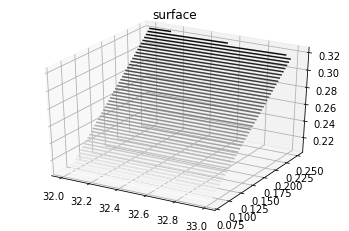

In [25]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.contour3D(K, T, vol, 50, cmap='binary')
ax.set_title('surface');